# 1. Settings

## 1.1 User variables

In [1]:
MAX_DAY = 4
NB_RUNS = 30

TARGETS = ["M15"]
HEURISTICS = ["try_all_atoms", "max_coverage_static"] #["max_coverage_static"] #["try_all_atoms", "max_coverage_dynamic", "max_coverage_static", "max_diversity"]
THREADS = 8
USE_NAN = True

DATA_PATH = "tmp/data_discrete.csv"

# 1.2 Dev variables

In [2]:
RANDOM_SEED = 0

INPUT_DATA_DISCRETE = "tmp/data_discrete.csv"
OUTPUT_CSV = "tmp/lfit_output.csv"

VERBOSE = True

## 1.3 Imports

In [3]:
import pandas as pd
import numpy
import random
import pylfit
import os

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

## 1.4 Constants

In [4]:
# Constants
DEBUG = False

# 2. Data Loading

# DEBUG

In [5]:
# DEBUG
print("Training dataset:")
df = pd.read_csv(DATA_PATH)
cols = [c for c in df.columns if c not in TARGETS]

display(df)

for target in TARGETS:
    for val in df[target].unique():
        print(val,len(df[df[target] == val]))

Training dataset:


,M15,Abies,Juniperus,Larix,Picea,Pinus,Tsuga,Acer,Alnus,Betula,...,Myrica,Phytolithe,Poaceae,Rosaceae,Sarcobatus,Thalictrum,Typha,Spore_monolete_,Spore_trilete,Aquatics
0,0,1,1,2,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
1,0,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,2,2,0
2,0,1,2,2,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,1,2,1,1,0,0,2,1,...,1,0,0,1,0,0,0,0,0,0
4,1,2,0,2,1,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,0,1,2,2,0,0,0,0,2,...,1,0,1,0,0,0,2,0,0,0
58,0,0,1,1,1,1,0,0,0,2,...,1,0,1,0,1,0,1,0,0,1
59,0,0,2,1,1,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
60,0,0,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


0 42
1 19
2 1


In [6]:
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "body", "rule_size"])

for run_id in range(NB_RUNS):
    # Shuffle variables
    random.shuffle(col_order)
    df = df[col_order]

    FEATURES = [c for c in df.columns if c not in TARGETS]

    df.to_csv("tmp/lfit_input.csv")

    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
    model.compile(algorithm="pride") # model.compile(algorithm="pride")
    model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":0, "threads":THREADS})

    # Save rules
    rules_data = []

    for r in model.rules:
        body = ""
        for i in sorted(list(r.body.items())):
            body += i[1].to_string() + ", "
        if (len(body)>0):
            body = body[:-2]
        rules_data.append([r.head.variable, r.head.value, body, r.size(),r]) #, r.to_string()])

    df_rules = pd.DataFrame(rules_data, columns=["head_variable", "head_value", "body", "rule_size","raw_rule"]) #, "rule_raw_form"])

    nb_rules_of_run = len(df_rules)
    nb_rules_total_before = len(df_output)

    df_output = pd.concat([df_output,df_rules]).reset_index(drop=True)
    df_output.drop_duplicates(subset=["head_variable", "head_value", "body", "rule_size"], inplace=True)

    nb_new_rules = len(df_output) - nb_rules_total_before
    nb_duplicate_rules = nb_rules_of_run - nb_new_rules
    
    print("Run",str(run_id+1)+"/"+str(NB_RUNS),"- new rules found:", nb_new_rules, "- total:",len(df_output),"- duplicate:",nb_duplicate_rules)

    df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)


Run 1/30 - new rules found: 231 - total: 231 - duplicate: 0
Run 2/30 - new rules found: 146 - total: 377 - duplicate: 81
Run 3/30 - new rules found: 99 - total: 476 - duplicate: 172
Run 4/30 - new rules found: 112 - total: 588 - duplicate: 138
Run 5/30 - new rules found: 76 - total: 664 - duplicate: 171
Run 6/30 - new rules found: 82 - total: 746 - duplicate: 173
Run 7/30 - new rules found: 52 - total: 798 - duplicate: 184
Run 8/30 - new rules found: 51 - total: 849 - duplicate: 205
Run 9/30 - new rules found: 39 - total: 888 - duplicate: 176
Run 10/30 - new rules found: 24 - total: 912 - duplicate: 274
Run 11/30 - new rules found: 29 - total: 941 - duplicate: 238
Run 12/30 - new rules found: 50 - total: 991 - duplicate: 219
Run 13/30 - new rules found: 19 - total: 1010 - duplicate: 190
Run 14/30 - new rules found: 40 - total: 1050 - duplicate: 220
Run 15/30 - new rules found: 31 - total: 1081 - duplicate: 149
Run 16/30 - new rules found: 1 - total: 1082 - duplicate: 220
Run 17/30 - ne

,head_variable,head_value,body,rule_size,raw_rule
0,M15,0,"Ambrosia(1), Artemesia(2), Cyperaceae(2), Juni...",4,"M15(0) :- Ambrosia(1), Artemesia(2), Cyperacea..."
1,M15,0,"Artemesia(2), Asteraceae(0)",2,"M15(0) :- Artemesia(2), Asteraceae(0)."
2,M15,0,"Artemesia(2), Cyperaceae(2), Salix(1)",3,"M15(0) :- Artemesia(2), Cyperaceae(2), Salix(1)."
3,M15,0,"Artemesia(2), Juniperus(2), Quercus(1)",3,"M15(0) :- Artemesia(2), Juniperus(2), Quercus(1)."
4,M15,0,"Artemesia(2), Cyperaceae(2), Poaceae(1)",3,"M15(0) :- Artemesia(2), Cyperaceae(2), Poaceae..."
...,...,...,...,...,...
1361,M15,0,"Alnus(0), Asteraceae(1), Typha(1)",3,"M15(0) :- Alnus(0), Asteraceae(1), Typha(1)."
1362,M15,0,"Asteraceae(1), Rosaceae(0), Typha(1)",3,"M15(0) :- Asteraceae(1), Rosaceae(0), Typha(1)."
1368,M15,0,"Ambrosia(1), Asteraceae(1), Typha(1)",3,"M15(0) :- Ambrosia(1), Asteraceae(1), Typha(1)."
1399,M15,1,"Asteraceae(1), Pinus(2), Spore_trilete(0), Ulm...",4,"M15(1) :- Asteraceae(1), Pinus(2), Spore_trile..."


# Evaluation

In [7]:
def score_rule(rule,df):
    true_pos = 0
    false_pos = 0
    unknown_true_pos = 0
    unknown_false_pos = 0

    for idx, row in df.iterrows():
        matches = "FULL"
        for (var,val) in rule.body.items():
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val.value)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                true_pos += 1
            else:
                false_pos += 1
        elif matches == "PARTIAL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                unknown_true_pos += 1
            else:
                unknown_false_pos += 1

    if (true_pos + false_pos) == 0:
        accuracy = 0
    else:
        accuracy = true_pos / (true_pos + false_pos)

    if (true_pos + unknown_false_pos) == 0:
        unknown_accuracy = 0
    else:
        unknown_accuracy = true_pos / (true_pos + unknown_false_pos)

    return true_pos, false_pos, accuracy, unknown_true_pos, unknown_false_pos, unknown_accuracy

In [8]:
TRAINING_DATASET = INPUT_DATA_DISCRETE
TEST_DATASET = None

for dataset, state  in [(TRAINING_DATASET, "train"), (TEST_DATASET, "test")]:
    if dataset is None:
        break
    #print("Evaluation of rules on",state,":",dataset)
    true_pos = []
    false_pos = []
    accuracy = []
    unknown_true_pos = []
    unknown_false_pos = []
    unknown_accuracy = []

    df = pd.read_csv(dataset)
    cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
    df[cols] = df[cols].astype('Int64')
    df[cols] = df[cols].astype('string')
    if not USE_NAN:
        df = df.dropna()
    else:
        df = df.fillna("?")

    for idx, row in df_output.iterrows():
        tp, fp, acc, utp, ufp, uacc = score_rule(row["raw_rule"], df)
        true_pos += [tp]
        false_pos += [fp]
        accuracy += [acc]
        unknown_true_pos += [utp]
        unknown_false_pos += [ufp]
        unknown_accuracy += [uacc]
        print("\r",str(idx+1)+"/"+str(len(df_output)),end="")

    df_output["true_positives"] = true_pos
    df_output["false_positives"] = false_pos
    df_output["accuracy"] = accuracy
    #df_output["unknown_true_positives"] = unknown_true_pos
    #df_output["unknown_false_positives"] = unknown_false_pos
    #df_output["unknown_accuracy"] = unknown_accuracy
    print()


df_output = df_output.sort_values(["accuracy","true_positives"],ascending=False)
df_output.drop(["raw_rule"], axis=1,inplace=True)

df_output = df_output.drop_duplicates()
df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)

 1402/1286


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy
937,M15,0,"Agoseris(0), Alnus(0), Corylus(0), Cyperaceae(1)",4,15,0,1.0
513,M15,0,"Acer(0), Alnus(0), Aquatics(0), Corylus(0)",4,13,0,1.0
518,M15,0,"Acer(0), Alnus(0), Aquatics(0), Pinus(1)",4,12,0,1.0
1122,M15,0,"Acer(0), Ambrosia(0), Juniperus(1)",3,12,0,1.0
720,M15,0,"Chenopodiaceae(1), Pinus(1)",2,11,0,1.0
...,...,...,...,...,...,...,...
1265,M15,0,"Alnus(0), Chenopodiaceae(0), Larix(1), Salix(1)",4,1,0,1.0
1274,M15,0,"Chenopodiaceae(1), Juniperus(0), Salix(0)",3,1,0,1.0
1276,M15,1,"Ambrosia(0), Chenopodiaceae(1), Pinus(2), Sali...",4,1,0,1.0
1368,M15,0,"Ambrosia(1), Asteraceae(1), Typha(1)",3,1,0,1.0


In [9]:
TOP_K_RULES = 5
MIN_SUPPORT = 1

VEN_TOP_K_RULES = 200

TARGETS = ["M15"]

import pandas as pd
import numpy
from upsetplot import UpSet
import matplotlib.pyplot as plt

LEVELS = df_output["head_value"].nunique()
LEVELS

3

In [10]:
def decode(body,include_value=True):
    conditions = []
    body = body.split(", ")

    for token in body:
        condition = token.split("(")[0].strip()
        val = token.split("(")[1].split(")")[0].strip()
        #if condition in metabolite_mapping:
        #    condition = metabolite_mapping[condition]
        if include_value:
            condition += "("+val+")"
        conditions += [condition]
    return conditions

0


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_6579/3098058551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
937,M15,0,"Agoseris(0), Alnus(0), Corylus(0), Cyperaceae(1)",4,15,0,1.0,"[Agoseris(0), Alnus(0), Corylus(0), Cyperaceae...",15.0
513,M15,0,"Acer(0), Alnus(0), Aquatics(0), Corylus(0)",4,13,0,1.0,"[Acer(0), Alnus(0), Aquatics(0), Corylus(0)]",13.0
518,M15,0,"Acer(0), Alnus(0), Aquatics(0), Pinus(1)",4,12,0,1.0,"[Acer(0), Alnus(0), Aquatics(0), Pinus(1)]",12.0
1122,M15,0,"Acer(0), Ambrosia(0), Juniperus(1)",3,12,0,1.0,"[Acer(0), Ambrosia(0), Juniperus(1)]",12.0
1172,M15,0,"Acer(0), Pinus(1), Typha(0)",3,11,0,1.0,"[Acer(0), Pinus(1), Typha(0)]",11.0


['Acer(0)', 'Agoseris(0)', 'Alnus(0)', 'Ambrosia(0)', 'Aquatics(0)', 'Corylus(0)', 'Cyperaceae(1)', 'Juniperus(1)', 'Pinus(1)', 'Typha(0)']
10


true_pos  \
Acer(0) Agoseris(0) Alnus(0) Ambrosia(0) Aquatics(0) Corylus(0) Cyperaceae(1) Juniperus(1) Pinus(1) Typha(0)             
False   True        True     False       False       True       True          False        False    False           15   
True    False       False    False       False       False      False         False        True     True            11   
                             True        False       False      False         True         False    False           12   
                    True     False       True        False      False         False        True     False           12   
                                                     True       False         False        False    False           13   

                                                                                                              false_pos  \
Acer(0) Agoseris(0) Alnus(0) Ambrosia(0) Aquatics(0) Corylus(0) Cyperaceae(1) Juniperus(1) Pinus(1) Typha(0)              
False   True        True     False       False       True       True          False        False    False             0   
True    False       False    False       False       False      False         False        True     True              0   
                             True        False       False      False         True         False    False             0   
                    True     False       True        False      False         False        True     False             0   
                                                     True       False         False        False    False             0   

                                                                                                              accuracy  \
Acer(0) Agoseris(0) Alnus(0) Ambrosia(0) Aquatics(0) Corylus(0) Cyperaceae(1) Juniperus(1) Pinus(1) Typha(0)             
False   True        True     False       False       True       True          False        False    False        100.0   
True    False       False    False       False       False      False         False        True     True         100.0   
                             True        False       False      False         True         False    False        100.0   
                    True     False       True        False      False         False        True     False        100.0   
                                                     True       False         False        False    False        100.0   

                                                                                                              confidence  
Acer(0) Agoseris(0) Alnus(0) Ambrosia(0) Aquatics(0) Corylus(0) Cyperaceae(1) Juniperus(1) Pinus(1) Typha(0)              
False   True        True     False       False       True       True          False        False    False           15.0  
True    False       False    False       False       False      False         False        True     True            11.0  
                             True        False       False      False         True         False    False           12.0  
                    True     False       True        False      False         False        True     False           12.0  
                                                     True       False         False        False    False           13.0

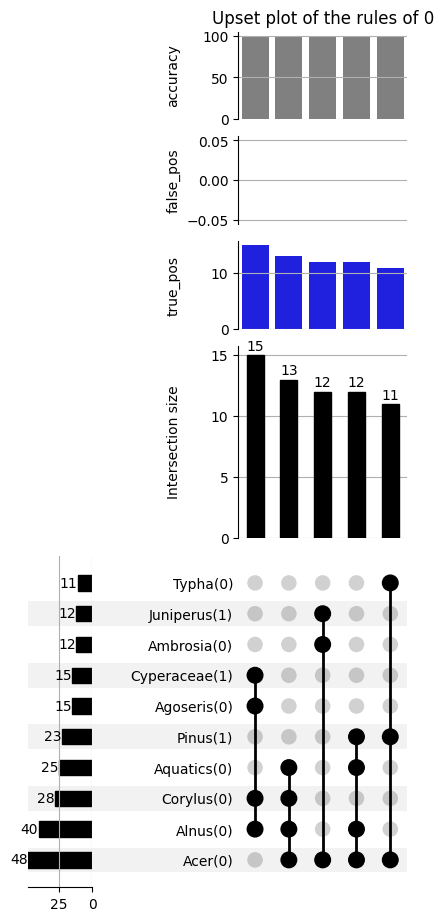

1


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_6579/3098058551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
173,M15,1,"Asteraceae(2), Chenopodiaceae(2), Ulmus(1)",3,5,0,1.0,"[Asteraceae(2), Chenopodiaceae(2), Ulmus(1)]",5.0
175,M15,1,"Asteraceae(2), Betula(1), Chenopodiaceae(2)",3,5,0,1.0,"[Asteraceae(2), Betula(1), Chenopodiaceae(2)]",5.0
140,M15,1,"Phytolithe(0), Salix(2)",2,4,0,1.0,"[Phytolithe(0), Salix(2)]",4.0
177,M15,1,"Asteraceae(2), Chenopodiaceae(2), Juniperus(2)",3,4,0,1.0,"[Asteraceae(2), Chenopodiaceae(2), Juniperus(2)]",4.0
880,M15,1,"Aquatics(1), Betula(1), Typha(2)",3,4,0,1.0,"[Aquatics(1), Betula(1), Typha(2)]",4.0


['Aquatics(1)', 'Asteraceae(2)', 'Betula(1)', 'Chenopodiaceae(2)', 'Juniperus(2)', 'Phytolithe(0)', 'Salix(2)', 'Typha(2)', 'Ulmus(1)']
9


true_pos  \
Aquatics(1) Asteraceae(2) Betula(1) Chenopodiaceae(2) Juniperus(2) Phytolithe(0) Salix(2) Typha(2) Ulmus(1)             
False       False         False     False             False        True          True     False    False            4   
            True          False     True              False        False         False    False    True             5   
                                                      True         False         False    False    False            4   
                          True      True              False        False         False    False    False            5   
True        False         True      False             False        False         False    True     False            4   

                                                                                                             false_pos  \
Aquatics(1) Asteraceae(2) Betula(1) Chenopodiaceae(2) Juniperus(2) Phytolithe(0) Salix(2) Typha(2) Ulmus(1)              
False       False         False     False             False        True          True     False    False             0   
            True          False     True              False        False         False    False    True              0   
                                                      True         False         False    False    False             0   
                          True      True              False        False         False    False    False             0   
True        False         True      False             False        False         False    True     False             0   

                                                                                                             accuracy  \
Aquatics(1) Asteraceae(2) Betula(1) Chenopodiaceae(2) Juniperus(2) Phytolithe(0) Salix(2) Typha(2) Ulmus(1)             
False       False         False     False             False        True          True     False    False        100.0   
            True          False     True              False        False         False    False    True         100.0   
                                                      True         False         False    False    False        100.0   
                          True      True              False        False         False    False    False        100.0   
True        False         True      False             False        False         False    True     False        100.0   

                                                                                                             confidence  
Aquatics(1) Asteraceae(2) Betula(1) Chenopodiaceae(2) Juniperus(2) Phytolithe(0) Salix(2) Typha(2) Ulmus(1)              
False       False         False     False             False        True          True     False    False            4.0  
            True          False     True              False        False         False    False    True             5.0  
                                                      True         False         False    False    False            4.0  
                          True      True              False        False         False    False    False            5.0  
True        False         True      False             False        False         False    True     False            4.0

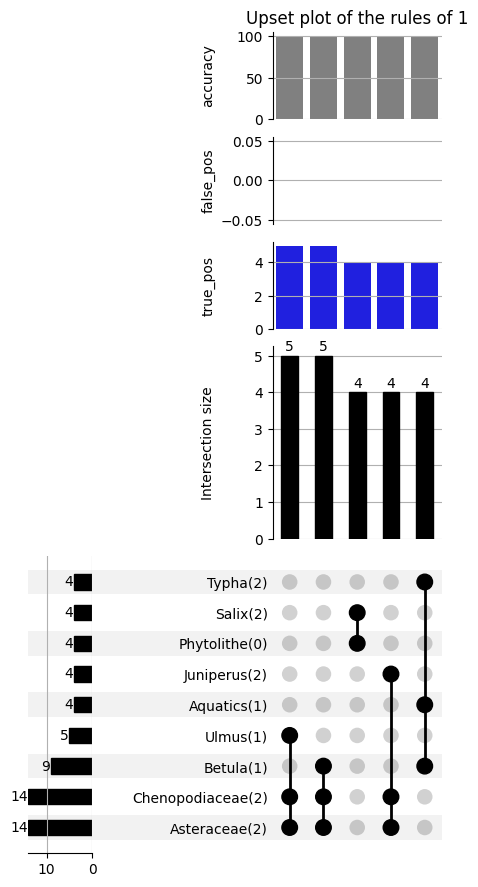

2


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_6579/3098058551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
212,M15,2,"Ambrosia(0), Myrica(2), Typha(2)",3,1,0,1.0,"[Ambrosia(0), Myrica(2), Typha(2)]",1.0
226,M15,2,"Pinus(2), Spore_trilete(1)",2,1,0,1.0,"[Pinus(2), Spore_trilete(1)]",1.0
587,M15,2,"Myrica(2), Pinus(2), Sarcobatus(1)",3,1,0,1.0,"[Myrica(2), Pinus(2), Sarcobatus(1)]",1.0
475,M15,2,"Abies(1), Myrica(2), Typha(2)",3,1,0,1.0,"[Abies(1), Myrica(2), Typha(2)]",1.0
474,M15,2,"Spore_trilete(1), Typha(2)",2,1,0,1.0,"[Spore_trilete(1), Typha(2)]",1.0


['Abies(1)', 'Ambrosia(0)', 'Myrica(2)', 'Pinus(2)', 'Sarcobatus(1)', 'Spore_trilete(1)', 'Typha(2)']
7


true_pos  \
Abies(1) Ambrosia(0) Myrica(2) Pinus(2) Sarcobatus(1) Spore_trilete(1) Typha(2)             
False    False       False     False    False         True             True             1   
                               True     False         True             False            1   
                     True      True     True          False            False            1   
         True        True      False    False         False            True             1   
True     False       True      False    False         False            True             1   

                                                                                 false_pos  \
Abies(1) Ambrosia(0) Myrica(2) Pinus(2) Sarcobatus(1) Spore_trilete(1) Typha(2)              
False    False       False     False    False         True             True              0   
                               True     False         True             False             0   
                     True      True     True          False            False             0   
         True        True      False    False         False            True              0   
True     False       True      False    False         False            True              0   

                                                                                 accuracy  \
Abies(1) Ambrosia(0) Myrica(2) Pinus(2) Sarcobatus(1) Spore_trilete(1) Typha(2)             
False    False       False     False    False         True             True         100.0   
                               True     False         True             False        100.0   
                     True      True     True          False            False        100.0   
         True        True      False    False         False            True         100.0   
True     False       True      False    False         False            True         100.0   

                                                                                 confidence  
Abies(1) Ambrosia(0) Myrica(2) Pinus(2) Sarcobatus(1) Spore_trilete(1) Typha(2)              
False    False       False     False    False         True             True             1.0  
                               True     False         True             False            1.0  
                     True      True     True          False            False            1.0  
         True        True      False    False         False            True             1.0  
True     False       True      False    False         False            True             1.0

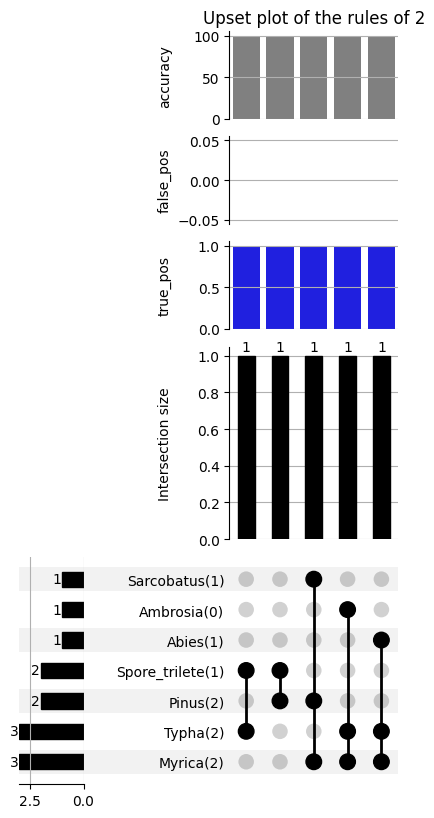

In [11]:
df_raw = df_output.copy()

df_raw["features"] = df_raw["body"].apply(lambda x: decode(x))

for head in df_raw["head_value"].unique():
    print(head)
    df = df_raw[(df_raw["head_value"] == head) & (df_raw["true_positives"] >= MIN_SUPPORT)]
    df["confidence"] = df["true_positives"] * df["accuracy"]
    df = df.sort_values("confidence", ascending=False).head(TOP_K_RULES)
    #df = df.sort_values("true_positives", ascending=False).head(TOP_K_RULES)

    display(df)

    features = set()
    for idx, row in df.iterrows():
        for i in row["features"]:
            features.add(i)

    features = list(features)
    features.sort()

    print(features)
    print(len(features))

    df_features = pd.DataFrame(columns=features)

    for idx, row in df.iterrows():
        data = {key:[False] for key in features}
        for condition in row["features"]:
            data[condition] = [True]
        df_features = pd.concat([df_features, pd.DataFrame(data)], axis=0).astype({key:bool for key in features})

    df_features["true_pos"] = df["true_positives"].values
    df_features["false_pos"] = df["false_positives"].values
    df_features["accuracy"] = df["accuracy"].values * 100
    df_features["confidence"] = df["confidence"].values
    df = df_features.reset_index(drop=True)

    # Clean useless column
    for col in features:
        if (not True in list(df[col].unique())):
            df = df.drop([col], axis=1)

    #display(df)

    conditions = [c for c in list(df.columns) if c not in ["true_pos","false_pos","accuracy","confidence"]]
    df = df.groupby(conditions).sum(numeric_only=True)
    display(df)

    upset = UpSet(df, show_counts=True, sort_by="cardinality", sum_over='confidence', subset_size="sum")
    #upset.add_catplot(kind="bar",value="false_pos")
    upset.add_catplot(kind="bar",value="true_pos", color="blue")
    upset.add_catplot(kind="bar",value="false_pos", color="red")
    upset.add_catplot(kind="bar",value="accuracy", color="gray")
    upset.plot()
    plt.title("Upset plot of the rules of "+str(head), loc="center")
    plt.savefig("tmp/upset_plot_lfit_"+str(head)+"_top_"+str(TOP_K_RULES)+"_lvl_"+str(LEVELS)+".pdf",bbox_inches='tight')
    plt.show()


# Vendiagram

In [12]:
def coverage(head_var, head_val, body,df):
    true_pos = 0
    false_pos = 0

    #print(body)

    conditions = body.split("), ")

    body = []
    for token in conditions:
        var = token.split("(")[0].strip()
        val = token.split("(")[1].split("(")[0].replace(")","").replace(".","").strip()
        if val.isdigit():
            val = int(val)
        body+= [(var,val)]

    #print((head_var, head_val), body)
        
    true_pos = []
    false_pos = []
    unknown_true_pos = []
    unknown_false_pos = []

    for idx, row in df.iterrows():
        matches = "FULL"
        for var,val in body:
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[head_var]) == str(head_val):
                true_pos += [idx]
            else:
                false_pos += [idx]
        elif matches == "PARTIAL":
            if str(row[head_var]) == str(head_val):
                unknown_true_pos += [idx]
            else:
                unknown_false_pos += [idx]

    
    #print(len(true_pos), len(false_pos), len(unknown_true_pos), len(unknown_false_pos))
    return true_pos, false_pos, unknown_true_pos, unknown_false_pos
    
df = pd.read_csv(INPUT_DATA_DISCRETE)
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')
df = df.fillna("?")
display(df)

tp, fp, utp, ufp = coverage("M15", "0", "Abies(1), Pinus(1)", df)
print(len(tp), len(fp), len(utp), len(ufp))

,M15,Abies,Juniperus,Larix,Picea,Pinus,Tsuga,Acer,Alnus,Betula,...,Myrica,Phytolithe,Poaceae,Rosaceae,Sarcobatus,Thalictrum,Typha,Spore_monolete_,Spore_trilete,Aquatics
0,0,1,1,2,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
1,0,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,2,2,0
2,0,1,2,2,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,1,2,1,1,0,0,2,1,...,1,0,0,1,0,0,0,0,0,0
4,1,2,0,2,1,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,0,1,2,2,0,0,0,0,2,...,1,0,1,0,0,0,2,0,0,0
58,0,0,1,1,1,1,0,0,0,2,...,1,0,1,0,1,0,1,0,0,1
59,0,0,2,1,1,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
60,0,0,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


9 5 0 0


 200 / 200
Remaining: 42
[(0, 15, 0), (1, 13, 0), (2, 12, 0), (3, 12, 0), (4, 11, 0), (5, 11, 0), (6, 11, 0), (7, 11, 0), (8, 11, 0), (9, 11, 0), (10, 10, 0), (11, 10, 0), (12, 10, 0), (13, 9, 0), (14, 9, 0), (15, 9, 0), (16, 9, 0), (17, 9, 0), (18, 9, 0), (19, 9, 0), (20, 9, 0), (21, 9, 0), (22, 9, 0), (23, 9, 0), (24, 8, 0), (25, 8, 0), (26, 8, 0), (27, 8, 0), (28, 8, 0), (29, 8, 0), (30, 8, 0), (31, 8, 0), (32, 8, 0), (33, 8, 0), (34, 8, 0), (35, 8, 0), (36, 8, 0), (37, 8, 0), (38, 8, 0), (39, 8, 0), (40, 8, 0), (41, 8, 0), (42, 8, 0), (43, 7, 0), (44, 7, 0), (45, 7, 0), (46, 7, 0), (47, 7, 0), (48, 7, 0), (49, 7, 0), (50, 7, 0), (51, 7, 0), (52, 7, 0), (53, 7, 0), (54, 7, 0), (55, 7, 0), (56, 7, 0), (57, 7, 0), (58, 7, 0), (59, 7, 0), (60, 7, 0), (61, 7, 0), (62, 7, 0), (63, 6, 0), (64, 6, 0), (65, 6, 0), (66, 6, 0), (67, 6, 0), (68, 6, 0), (69, 6, 0), (70, 6, 0), (71, 6, 0), (72, 6, 0), (73, 6, 0), (74, 6, 0), (75, 6, 0), (76, 6, 0), (77, 6, 0), (78, 6, 0), (79, 6, 0), (80, 6, 0),

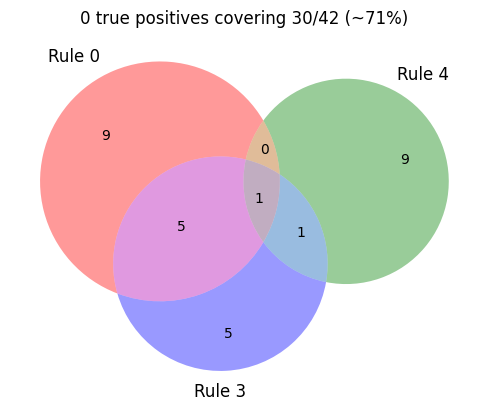

Rule 0: ['Agoseris(0)', 'Alnus(0)', 'Corylus(0)', 'Cyperaceae(1)']
Rule 4: ['Acer(0)', 'Pinus(1)', 'Typha(0)']
Rule 3: ['Acer(0)', 'Ambrosia(0)', 'Juniperus(1)']


/opt/anaconda3/envs/homi-lung/lib/python3.11/site-packages/matplotlib_venn/layout/venn3/pairwise.py:97: UserWarning: All circles have zero area.
  warnings.warn("All circles have zero area.")


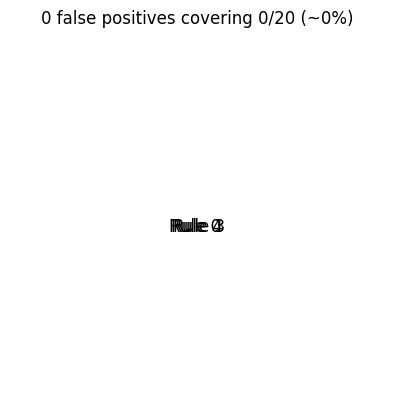

 200 / 200
Remaining: 19
[(0, 5, 0), (1, 5, 0), (2, 4, 0), (3, 4, 0), (4, 4, 0), (5, 3, 0), (6, 3, 0), (7, 3, 0), (8, 3, 0), (9, 3, 0), (10, 3, 0), (11, 3, 0), (12, 3, 0), (13, 3, 0), (14, 3, 0), (15, 3, 0), (16, 3, 0), (17, 3, 0), (18, 3, 0), (19, 3, 0), (20, 3, 0), (21, 3, 0), (22, 3, 0), (23, 2, 0), (24, 2, 0), (25, 2, 0), (26, 2, 0), (27, 2, 0), (28, 2, 0), (29, 2, 0), (30, 2, 0), (31, 2, 0), (32, 2, 0), (33, 2, 0), (34, 2, 0), (35, 2, 0), (36, 2, 0), (37, 2, 0), (38, 2, 0), (39, 2, 0), (40, 2, 0), (41, 2, 0), (42, 2, 0), (43, 2, 0), (44, 2, 0), (45, 2, 0), (46, 2, 0), (47, 2, 0), (48, 2, 0), (49, 2, 0), (50, 2, 0), (51, 2, 0), (52, 2, 0), (53, 2, 0), (54, 2, 0), (55, 2, 0), (56, 2, 0), (57, 2, 0), (58, 2, 0), (59, 2, 0), (60, 2, 0), (61, 2, 0), (62, 2, 0), (63, 2, 0), (64, 2, 0), (65, 2, 0), (66, 2, 0), (67, 2, 0), (68, 2, 0), (69, 2, 0), (70, 2, 0), (71, 2, 0), (72, 2, 0), (73, 2, 0), (74, 2, 0), (75, 2, 0), (76, 2, 0), (77, 2, 0), (78, 2, 0), (79, 2, 0), (80, 2, 0), (81, 2, 0), 

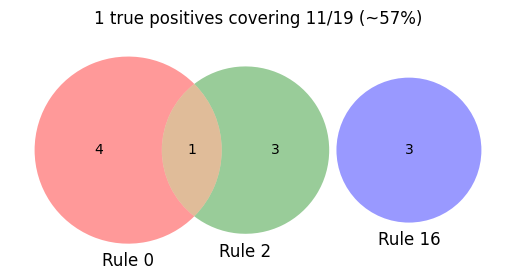

Rule 0: ['Asteraceae(2)', 'Chenopodiaceae(2)', 'Ulmus(1)']
Rule 2: ['Phytolithe(0)', 'Salix(2)']
Rule 16: ['Larix(2)', 'Myrica(2)']


/opt/anaconda3/envs/homi-lung/lib/python3.11/site-packages/matplotlib_venn/layout/venn3/pairwise.py:97: UserWarning: All circles have zero area.
  warnings.warn("All circles have zero area.")


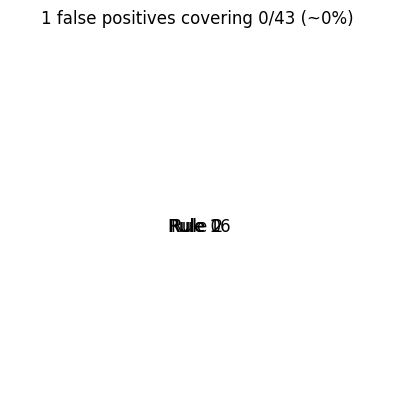

 27 / 27
Remaining: 1
[(0, 1, 0), (1, 1, 0), (2, 1, 0), (3, 1, 0), (4, 1, 0), (5, 1, 0), (6, 1, 0), (7, 1, 0), (8, 1, 0), (9, 1, 0), (10, 1, 0), (11, 1, 0), (12, 1, 0), (13, 1, 0), (14, 1, 0), (15, 1, 0), (16, 1, 0), (17, 1, 0), (18, 1, 0), (19, 1, 0), (20, 1, 0), (21, 1, 0), (22, 1, 0), (23, 1, 0), (24, 1, 0), (25, 1, 0), (26, 1, 0)]


IndexError: list index out of range

In [13]:
from matplotlib_venn import venn3

# find subset of rules of max size that cover all sample
df_data = pd.read_csv(INPUT_DATA_DISCRETE)
cols = [c for c in df_data.columns if c not in list(df_data.select_dtypes(exclude=["number"]).columns)]
df_data[cols] = df_data[cols].astype('Int64')
df_data[cols] = df_data[cols].astype('string')
df_data = df_data.fillna("?")
#df_data = df_data.dropna() # DBG remove if nan lfit mode
#display(df_data)
df_rules = df_output.copy()

for head_value in list(df_rules["head_value"].unique()):
    # Extract top rules
    df_rules = df_output.copy()
    df_rules = df_rules[(df_rules["head_value"] == head_value) & (df_rules["true_positives"] >= MIN_SUPPORT)]

    # DBG
    #df_rules = df_rules.sort_values("train_true_positives", ascending=False).reset_index(drop=True)
    #df_rules = df_rules.truncate(before=19417).reset_index(drop=True)
    df_rules = df_rules.sort_values("true_positives", ascending=False).reset_index(drop=True).head(VEN_TOP_K_RULES).reset_index(drop=True)
    #display(df_rules)

    # Compute covering
    rule_covering = {}
    for idx, row in df_rules.iterrows():
        tp, fp, utp, ufp = coverage(row["head_variable"], row["head_value"], row["body"], df_data)
        rule_covering[idx] = {"tp":set(tp), "fp":set(fp), "utp":set(utp), "ufp":set(ufp)}
        print("\r",idx+1,"/",len(df_rules),end="")
    print()

    # Greedy search for minimal set covering
    remaining = set(df_data[df_data[TARGETS[0]] == head_value].index.values.tolist())
    total_to_cover = len(remaining)
    selection = []
    while (len(remaining) > 0) and (len(rule_covering) > 0) and (len(selection) < 3):
        print("Remaining:",len(remaining))

        covering = []
        for rule_id in rule_covering:
            new_tp = len(remaining.intersection(rule_covering[rule_id]["tp"])) + len(remaining.intersection(rule_covering[rule_id]["utp"]))
            if (new_tp > 0):
                covering += [(rule_id, new_tp, len(rule_covering[rule_id]["fp"]) + len(rule_covering[rule_id]["ufp"]))]
        covering.sort(key = lambda x: (x[1],-x[2]),reverse=True) # Maximize TP, minimize FP
        print(covering)

        if covering[0][1] == 0:
            print("No rule cover the remaining observations")
            break

        top_rule_id = covering[0][0]
        selection += [top_rule_id]
        remaining = remaining - rule_covering[top_rule_id]["tp"] - rule_covering[top_rule_id]["utp"]
        #del rule_covering[top_rule_id]


    # True positives covering
    set1 = set(rule_covering[selection[0]]["tp"]).union(rule_covering[selection[0]]["utp"])
    set2 = set(rule_covering[selection[1]]["tp"]).union(rule_covering[selection[1]]["utp"])
    set3 = set(rule_covering[selection[2]]["tp"]).union(rule_covering[selection[2]]["utp"])

    venn3([set1, set2, set3], ("Rule "+str(selection[0]), "Rule "+str(selection[1]), "Rule "+str(selection[2])))

    nb_covered = total_to_cover-len(remaining)
    pct_covered = int(nb_covered / total_to_cover * 100)
    r0 = decode(df_rules["body"].iloc[[selection[0]]].values[0])
    r1 = decode(df_rules["body"].iloc[[selection[1]]].values[0])
    r2 = decode(df_rules["body"].iloc[[selection[2]]].values[0])
    plt.title(str(head_value)+" true positives covering "+str(nb_covered)+"/"+str(total_to_cover)+" (~"+str(pct_covered)+"%)")
    print("Rule "+str(selection[0])+": "+str(r0))
    print("Rule "+str(selection[1])+": "+str(r1))
    print("Rule "+str(selection[2])+": "+str(r2))
    #plt.text(1, 0, "Rule "+str(selection[0])+": "+str(r0), fontsize = 12) 
    #plt.text(1, -0.1, "Rule "+str(selection[1])+": "+str(r1), fontsize = 12)
    #plt.text(1, -0.2, "Rule "+str(selection[2])+": "+str(r2), fontsize = 12)
    plt.savefig("tmp/ven_diag_"+str(head_value)+"_TP.pdf",bbox_inches='tight')
    plt.show()

    #if dataset_name == "PREVHAP":
    # False positives covering
    set1 = set(rule_covering[selection[0]]["ufp"]).union(rule_covering[selection[0]]["fp"])
    set2 = set(rule_covering[selection[1]]["ufp"]).union(rule_covering[selection[1]]["fp"])
    set3 = set(rule_covering[selection[2]]["ufp"]).union(rule_covering[selection[2]]["fp"])

    venn3([set1, set2, set3], ("Rule "+str(selection[0]), "Rule "+str(selection[1]), "Rule "+str(selection[2])))

    total_to_cover = len(set(df_data[df_data[TARGETS[0]] != head_value].index.values.tolist()))
    nb_covered = set1
    nb_covered.update(set2)
    nb_covered.update(set3)
    nb_covered = len(nb_covered)
    pct_covered = int(nb_covered / total_to_cover * 100)
    r0 = decode(df_rules["body"].iloc[[selection[0]]].values[0])
    r1 = decode(df_rules["body"].iloc[[selection[1]]].values[0])
    r2 = decode(df_rules["body"].iloc[[selection[2]]].values[0])
    print("Rule "+str(selection[0])+": "+str(r0))
    print("Rule "+str(selection[1])+": "+str(r1))
    print("Rule "+str(selection[2])+": "+str(r2))
    plt.title(str(head_value)+" false positives covering "+str(nb_covered)+"/"+str(total_to_cover)+" (~"+str(pct_covered)+"%)")
    #plt.text(1, 0, "Rule "+str(selection[0])+": "+str(r0), fontsize = 12) 
    #plt.text(1, -0.1, "Rule "+str(selection[1])+": "+str(r1), fontsize = 12)
    #plt.text(1, -0.2, "Rule "+str(selection[2])+": "+str(r2), fontsize = 12)
    plt.savefig("tmp/ven_diag_"+str(head_value)+"_FP.pdf",bbox_inches='tight')
    plt.show()



# TODO